# RISS에서의 키워드에 따른 서지 정보 크롤링과 분석

### 개발환경 확인

In [1]:
import sys
sys.executable

'/Users/heavenly/opt/anaconda3/envs/complex/bin/python3.10'

# 1. RISS로부터의 크롤링하기

In [2]:
from selenium import webdriver
from selenium.webdriver.chrome.options import Options
from selenium.webdriver.common.by import By
from selenium.webdriver.common.action_chains import ActionChains
from bs4 import BeautifulSoup

import pandas as pd
import numpy as np
import requests
import time
import os
import re

In [3]:
def extract_numbers(string):
    numbers = re.findall(r'\d+', string)
    return int(''.join(numbers))

In [16]:
uid = '' # 여기에 자신의 아이디를 입력
passcode = '' # 여기에 자신의 패스워드를 입력

In [17]:
headers = {'User-Agent':'Mozilla/5.0 (Macintosh; Intel Mac OS X 10_15_7) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/97.0.4692.71 Safari/537.36'}

def get_datatable(search_key, is_show=True):
    start_time = time.time()
    
    # '%2B'는 더하기를 의미함
    search_key = search_key.replace(' ', '%2B') 
    
    # 웹 드라이버 생성
    chrome_options = Options()
    
    if not is_show:
        chrome_options.add_argument('--headless')  # 브라우저 창을 표시하지 않음
        
    driver = webdriver.Chrome(options=chrome_options)

    # 로그인 페이지 접속
    driver.get('https://portal.dankook.ac.kr/login.jsp')
    # 사용자 이름과 비밀번호 입력
    username_input = driver.find_element(By.NAME, 'user_id')
    password_input = driver.find_element(By.NAME, 'user_password')

    username_input.send_keys(uid) 
    password_input.send_keys(passcode)

    login_btn = driver.find_element(By.XPATH, '//button[contains(text(), "로그인")]')
    login_btn.click()
    
    i = 0
    url = 'http://www.riss.kr/search/Search.do?isDetailSearch=N&searchGubun=true&viewYn=OP&queryText=&strQuery='
    url += search_key
    url += '&exQuery=&exQueryText=&order=%2FDESC&onHanja=false&strSort=RANK&p_year1=&p_year2=&iStartCount='
    url += str(i*100) #한 페이지에 100개씩 출력
    url += '&orderBy=&mat_type=&mat_subtype=&fulltext_kind=&t_gubun=&learning_type=&ccl_code=&inside_outside=&fric_yn=&image_yn=&gubun=&kdc=&ttsUseYn=&l_sub_code=&fsearchMethod=&sflag=1&isFDetailSearch=N&pageNumber=1&resultKeyword=%EC%9D%B8%EA%B3%B5%EC%A7%80%EB%8A%A5+%EA%B5%90%EC%9C%A1+%ED%9A%A8%EA%B3%BC&fsearchSort=&fsearchOrder=&limiterList=&limiterListText=&facetList=&facetListText=&fsearchDB=&icate=re_a_kor&colName=re_a_kor&pageScale=100&isTab=Y&regnm=&dorg_storage=&language=&language_code=&clickKeyword=&relationKeyword=&query='
    url += search_key
    
    print(url)

    df = pd.DataFrame(columns = ['year', 'author', 'title', 'journal', 'vol', 'abstract', 'keyword', 'read', 'download'])
    
    driver.get(url)
    soup = BeautifulSoup(driver.page_source, "html.parser")
    total_cnt = extract_numbers(soup.select_one("dd").select_one('span').text)
    total_pages = total_cnt // 100 + 1
    
    for i in range(total_pages):
        url = 'http://www.riss.kr/search/Search.do?isDetailSearch=N&searchGubun=true&viewYn=OP&queryText=&strQuery='
        url += search_key
        url += '&exQuery=&exQueryText=&order=%2FDESC&onHanja=false&strSort=RANK&p_year1=&p_year2=&iStartCount='
        url += str(i*100) #한 페이지에 100개씩 출력
        url += '&orderBy=&mat_type=&mat_subtype=&fulltext_kind=&t_gubun=&learning_type=&ccl_code=&inside_outside=&fric_yn=&image_yn=&gubun=&kdc=&ttsUseYn=&l_sub_code=&fsearchMethod=&sflag=1&isFDetailSearch=N&pageNumber=1&resultKeyword=%EC%9D%B8%EA%B3%B5%EC%A7%80%EB%8A%A5+%EA%B5%90%EC%9C%A1+%ED%9A%A8%EA%B3%BC&fsearchSort=&fsearchOrder=&limiterList=&limiterListText=&facetList=&facetListText=&fsearchDB=&icate=re_a_kor&colName=re_a_kor&pageScale=100&isTab=Y&regnm=&dorg_storage=&language=&language_code=&clickKeyword=&relationKeyword=&query='
        url += search_key

        if (i != 0):
            driver.get(url)
            time.sleep(0.5)
            soup = BeautifulSoup(driver.page_source, "html.parser")

        articles = soup.select("#divContent > div > div.rightContent.wd756 > div > div.srchResultW > div.srchResultListW > ul > li")    

        original_window_handle = driver.current_window_handle

        for article in articles:
            title = article.select_one('p.title').text
            link = article.select_one('p.title').select_one('a')['href']

            items = article.select_one('p.etc').select('span')
            author = items[0].text
            year = items[2].text
            journal = items[3].text
            vol = items[len(items)-1].text
            abstract = article.select_one('p.preAbstract').text if article.select_one('p.preAbstract') is not None else ''

            url2 = 'http://www.riss.kr' + link
            driver.execute_script(f"window.open('{url2}', '_blank');")
            time.sleep(0.5)
            window_handles = driver.window_handles
            # 새로 열린 창으로 전환
            for handle in window_handles:
                if handle != original_window_handle:
                    driver.switch_to.window(handle)
                    break

            soup2 = BeautifulSoup(driver.page_source, 'html.parser')
            subitems = soup2.select_one('div.infoDetail.on').select('li')
            keywords = ''
            for item in subitems:
                if item.select_one('span.strong') is not None:
                    name = item.select_one('span.strong').text
                    if name == '주제어':
                        keys = item.select_one('div').text
                        utf8_str = keys.encode('utf-8').decode('utf-8') 
                        utf8_str = utf8_str.split(';')
                        stripped_list = [l.strip() for l in utf8_str]
                        keywords = ', '.join(stripped_list)
                        break


            # 조회수, 다운로드 수 저장
            read = extract_numbers(soup2.select_one('span#f_view.num').text)
            down = extract_numbers(soup2.select_one('span#f_usage.num').text)
            df.loc[len(df)] = [year, author, title, journal, vol, abstract, keywords, read, down]
            driver.close()
            driver.switch_to.window(original_window_handle)
            
            if (len(df) % 100 == 0):
                print(f"{len(df)} finished.")
    
    elapsed_time = time.time() - start_time
    
    driver.quit()
    
    return df, total_cnt, total_pages, elapsed_time

In [5]:
result_df, total_cnt, total_pages, tot_time = get_datatable('데이터 리터러시')

refine_df = result_df.drop_duplicates()
refine_df = refine_df[refine_df['keyword'] != '']
refine_df = refine_df[refine_df['abstract'] != '']
refine_df.reset_index(drop=True, inplace=True)
refine_df.to_excel('Data/riss_dl.xlsx')

WebDriverException: Message: Service /usr/local/bin/chromedriver unexpectedly exited. Status code was: -9


# 얻어온 정보들을 통합해서 정리

In [35]:
from langdetect import detect

# 한글 및 영어 제목에 대한 구분 
def get_title(title):
    ko_title = ''
    en_title = ''

    result = title.split('=')

    for item in result:
        lang = detect(item)
        
        if lang == 'ko':
            ko_title = item.strip()
        else:
            en_title = item.strip()
            
    return ko_title, en_title    

In [62]:
def get_keyword(keyword):
    ko_key = []
    en_key = []

    result = keyword.split(',')

    for item in result:
        try:
            item = item.strip()

            if len(item) > 2:
                lang = detect(item)

                if lang == 'ko':
                    ko_key.append(item)
                elif lang == 'en':
                    en_key.append(item)
        except:
            print('error occurred.')

    return ','.join(ko_key), ','.join(en_key) 

In [51]:
from nltk.tokenize import sent_tokenize

# 한글 및 영어 텍스트의 구분
def get_text(text):
    # 초록을 문장으로 분할
    sentences = sent_tokenize(text)

    korean_abstract = []
    english_abstract = []
    
    prev = 'ko'

    for sentence in sentences:
        try:
            # 문장의 언어 감지
            language = detect(sentence)

            if language == 'en':
                english_abstract.append(sentence)
                prev = language
            else:
                korean_abstract.append(sentence)
                prev = language
        except:
            if prev == 'en':
                english_abstract.append(sentence)
            else:
                korean_abstract.append(sentence)
            

    korean_abstract = '. '.join(korean_abstract)
    english_abstract = '. '.join(english_abstract)
    
    korean_abstract = korean_abstract.replace('\ufeff', ' ')
    english_abstract = english_abstract.replace('\ufeff', ' ')

    korean_abstract = korean_abstract.replace('\n', ' ')
    english_abstract = english_abstract.replace('\n', ' ')

    return korean_abstract, english_abstract

In [64]:
%%time

import pandas as pd

file_names = ['Data/riss_dl']
cats = ['Data Literacy']

for index, name in enumerate(file_names):
    df = pd.read_excel(name + '.xlsx', index_col=0)

    df['ko_title'] = None
    df['en_title'] = None
    df['ko_abstract'] = None
    df['en_abstract'] = None
    df['ko_keyword'] = None
    df['en_keyword'] = None
    df['category'] = cats[index]
    
    for i in range(len(df)):
        title1, title2 = get_title(df.title[i])
        text1, text2 = get_text(df.abstract[i])
        key1, key2 = get_keyword(df.keyword[i])
        df.loc[i, ['ko_title', 'ko_abstract', 'en_title', 'en_abstract', 'ko_keyword', 'en_keyword']] = [title1, text1, title2, text2, key1, key2]
        
    df.to_excel(name + '_r.xlsx')
    
    print(f"{name} finished")

Data/riss_dl finished
Data/riss_dil finished
error occurred.
Data/riss_aic finished
error occurred.
error occurred.
error occurred.
error occurred.
Data/riss_kc finished
CPU times: user 1min 56s, sys: 912 ms, total: 1min 57s
Wall time: 1min 57s


# 여기서부터 정제 작업. 한글 - 영어 번역 및 키워드 추출

In [65]:
def translate_text(target: str, text: str) -> dict:
    """Translates text into the target language.

    Target must be an ISO 639-1 language code.
    See https://g.co/cloud/translate/v2/translate-reference#supported_languages
    """
    from google.cloud import translate_v2 as translate

    translate_client = translate.Client()

    if isinstance(text, bytes):
        text = text.decode("utf-8")

    # Text can also be a sequence of strings, in which case this method
    # will return a sequence of results for each text.
    result = translate_client.translate(text, target_language=target)

    #print("Text: {}".format(result["input"]))
    #print("Translation: {}".format(result["translatedText"]))
    #print("Detected source language: {}".format(result["detectedSourceLanguage"]))

    return result

In [66]:
# 파일을 하나씩 열어서 영어 초록이 없는 경우는 한글 초록으로부터 영어 초록을 번역해서 생성하도록 한다.
import pandas as pd
import numpy as np

file_names = ['Data/riss_dl']

for name in file_names:
    df = pd.read_excel(f"{name}_r.xlsx", index_col=0)
    print(f"----- {name} begin -----")
    
    for i in range(len(df)):
        if df.loc[i, 'en_title'] is np.nan:
            #print(f"{i}th title processing.")
            if df.loc[i, 'ko_title'] is not np.nan:
                df.loc[i, 'en_title'] = translate_text("en", df.ko_title[i])['translatedText']  
            
        if df.loc[i, 'en_abstract'] is np.nan:
            #print(f"{i}th abstract processing.")
            if df.loc[i, 'ko_abstract'] is not np.nan:
                df.loc[i, 'en_abstract'] = translate_text("en", df.ko_abstract[i])['translatedText']
            
    #다시 저장하기
    df.to_excel(f"{name}_r2.xlsx")
    
    print(f"----- {name} end -----\n")

----- Data/riss_dl begin -----
----- Data/riss_dl end -----

----- Data/riss_dil begin -----
----- Data/riss_dil end -----

----- Data/riss_aic begin -----
----- Data/riss_aic end -----

----- Data/riss_kc begin -----
----- Data/riss_kc end -----



# 다 수정이 끝났으면 이번에는 키워드를 추출하는 작업을 진행한다.

### Huggingface에 있는 모델을 가져와서 Transformers Library를 이용해 처리한다.

In [1]:
from transformers import (
    TokenClassificationPipeline,
    AutoModelForTokenClassification,
    AutoTokenizer,
)
from transformers.pipelines import AggregationStrategy
import numpy as np

# Define keyphrase extraction pipeline
class KeyphraseExtractionPipeline(TokenClassificationPipeline):
    def __init__(self, model, *args, **kwargs):
        super().__init__(
            model=AutoModelForTokenClassification.from_pretrained(model),
            tokenizer=AutoTokenizer.from_pretrained(model),
            *args,
            **kwargs
        )

    def postprocess(self, all_outputs):
        results = super().postprocess(
            all_outputs=all_outputs,
            aggregation_strategy=AggregationStrategy.FIRST,
        )
        return np.unique([result.get("word").strip() for result in results])
    
model_name = "ml6team/keyphrase-extraction-distilbert-inspec"
extractor = KeyphraseExtractionPipeline(model=model_name)

In [53]:
# 파일을 하나씩 열어서 영어 초록이 없는 경우는 한글 초록으로부터 영어 초록을 번역해서 생성하도록 한다.
import pandas as pd
import numpy as np

file_names = ['Data/riss_dl']

for name in file_names:
    df = pd.read_excel(f"{name}_r2.xlsx", index_col=0)
    print(f"----- {name} begin -----")
    
    for i in range(len(df)):
        if df.loc[i, 'en_keyword'] is np.nan:
            text = df.loc[i, 'en_abstract']
            text = text.replace('\n', ' ').strip()
            
            if text is not np.nan:
                keys = extractor(text)
                
                if (len(keys) > 0):
                    df.loc[i, 'en_keyword'] = ','.join(keys)
            
    #다시 저장하기
    df['en_keyword'] = df['en_keyword'].str.lower()
    df.to_excel(f"{name}_r2.xlsx")    
    print(f"----- {name} end -----\n")

----- Data/riss_dl begin -----
----- Data/riss_dl end -----

----- Data/riss_dil begin -----
----- Data/riss_dil end -----

----- Data/riss_aic begin -----
----- Data/riss_aic end -----

----- Data/riss_kc begin -----
----- Data/riss_kc end -----



# 4개의 키워드에 대한 분석과 시각화

In [1]:
import pandas as pd

df1 = pd.read_excel('Data/riss_dl_r2.xlsx', index_col=0)

dfs = [df1]

# 중복되지 않는 유일한 데이터를 가지는 새로운 데이터프레임 생성
df_new = pd.concat(dfs).drop_duplicates().reset_index(drop=True)

In [2]:
df_new = df_new[~df_new.duplicated(subset='title', keep='first')]

In [3]:
df_new.reset_index(inplace=True, drop=True)

In [4]:
df_new.loc[:, 'data'] = 0

In [5]:
mask = df_new['title'].isin(df1['title'])
df_new.loc[mask, 'data'] = 1

In [7]:
df_new['sum'] = df_new['data'].sum(axis=1)

In [8]:
df_new['sum'].value_counts()

1    1711
2     296
3      13
Name: sum, dtype: int64

In [9]:
# 3개 주제에 포함되는 것들: 15
df_new[df_new['sum']==3]
# 13개는 데이터 + 디지털 + 인공지능 중복
# 2개는 데이터 + 디지털 + 지식정보 중복

,year,author,title,journal,vol,abstract,keyword,read,download,ko_title,...,en_abstract,ko_keyword,en_keyword,category,sciedu,data,digital,ai,knowledge,sum
31,2023,"주애리(Joo aeri),김미량(Kim miryang)",데이터 시각화 자료 활용 토론 수업이 초등학생의 데이터 리터러시에 미치는 효과,한국컴퓨터교육학회 학술발표대회논문집,Vol.27 No.2,교육부는 2022 개정 교육과정 총론 시안 발표에서 미래 세대의 핵심 역량으로 ‘디...,"인공지능융합교육, 데이터 리터러시, 데이터 시각화",3,6,데이터 시각화 자료 활용 토론 수업이 초등학생의 데이터 리터러시에 미치는 효과,...,In announcing the 2022 revised curriculum outl...,"인공지능융합교육,데이터 리터러시,데이터 시각화","data analysis,data literacy,data science,data ...",Data Literacy,0,1,1,1,0,3
99,2018,"홍명희,이순영",오픈 콘텐츠를 활용한 디지털 리터러시 학습 요소 구성과 활용,정보교육학회논문지,Vol.22 No.6,The development of artificial intelligence tec...,"디지털 리터러시, 디지털 리터러시 교육, 오픈 콘텐츠, 학습 요소 구성, 교육 방안...",0,0,오픈 콘텐츠를 활용한 디지털 리터러시 학습 요소 구성과 활용,...,The development of artificial intelligence tec...,"디지털 리터러시,디지털 리터러시 교육,오픈 콘텐츠,학습 요소 구성,교육 방안","digital literacy education,composition of digi...",Data Literacy,0,1,1,1,0,3
121,2022,"김슬기(Seul Ki Kim),김태영(Tae Young Kim)",요구 분석 모형을 활용한 인공지능 교육용 데이터셋 제공 라이브러리 설계,한국컴퓨터교육학회 학술발표대회논문집,Vol.26 No.2,인공지능 기술의 발달이 산업과 사회에 많은 영향을 주고 있으며 이러한 시대의 흐름에...,"AI/SW교육, 정보교육, 데이터셋, 파이썬라이브러리",19,22,요구 분석 모형을 활용한 인공지능 교육용 데이터셋 제공 라이브러리 설계,...,The development of artificial intelligence tec...,"정보교육,데이터셋,파이썬라이브러리","artificial intelligence,artificial intelligenc...",Data Literacy,0,1,1,1,0,3
145,2022,"홍지연,김영식",초등학생의 디지털·AI 리터러시 함양을 위한 컴퓨팅 사고력 기반 교수·학습 전략 개발,정보교육학회논문지,Vol.26 No.5,"인공지능, 빅데이터, 생명과학 산업 등이 선도하는 지식정보사회의 물결이 우리 삶의 ...","Digital‧AI literacy, Computational thinking, T...",115,131,초등학생의 디지털·AI 리터러시 함양을 위한 컴퓨팅 사고력 기반 교수·학습 전략 개발,...,"The wave of the knowledge information society,...","디지털‧AI 리터러시,컴퓨팅 사고력,교수·학습 전략,교수·학습 모델,초등학교","computational thinking,teaching-learning strat...",Data Literacy,0,1,1,1,0,3
236,2020,김진석 ( Kim Jin-seok ),초등영어 학습자를 위한 인공지능 리터러시의 빅 아이디와 성취기준,한국초등교육,Vol.31 No.특별호,본 연구의 목적은 초등영어학습자의 인공지능 리터러시를 함양하기 위한 빅 아이디어 및...,"Artificial intelligence literacy, Big ideas, A...",0,0,초등영어 학습자를 위한 인공지능 리터러시의 빅 아이디와 성취기준,...,The purpose of this paper is to suggest big id...,"인공지능 리터러시,빅 아이디어,성취기준",big ideas,Data Literacy,0,1,1,1,0,3
432,2022,유사라,5G 정보환경 정보전문가를 위한 윤리 리터러시 교육과정 모형연구,한국비블리아학회지,Vol.33 No.1,Ethical Issues increase when people engage in ...,"윤리 기준, 5G 정보환경 정보전문가, 이용자 경험(UX), 디지털화, 빅데이터, ...",106,84,5G 정보환경 정보전문가를 위한 윤리 리터러시 교육과정 모형연구,...,Ethical Issues increase when people engage in ...,"윤리 기준,5G 정보환경 정보전문가,이용자 경험(UX),디지털화,빅데이터,소셜미디어...","codes of ethics,5g information professionals,i...",Data Literacy,0,1,1,1,0,3
470,2021,"윤진영(Youn, Jin Young),김연형(Kim, Yeon Hyeoung),이채...",메타버스를 활용한 창작 기반 융합교육 프로그램 개발 연구,한국과학예술융합학회,Vol.39 No.5,급변하는 현대 사회에서 정보 기술과 인터넷 환경이 발전하면서 사회 전반은 디지털 전...,"Metaverse(메타버스), Art-Science Convergence(과학예술융...",629,511,메타버스를 활용한 창작 기반 융합교육 프로그램 개발 연구,...,With the development of information technology...,STEAM(융합인재교육),art-science convergence(과학예술융합),Data Literacy,0,1,1,1,0,3
484,2018,"최현희,정문성",초등학교 학생의 지식정보처리역량이 시민의식에 미치는 영향,시민교육연구,Vol.50 No.1,The purpose of this study is to investigate wh...,"knowledge information processing competence, i...",0,0,초등학교 학생의 지식정보처리역량이 시민의식에 미치는 영향,...,The purpose of this study is to investigate wh...,"지식정보처리역량,개인시민성,공동체 시민성,세계 시민성,비인지적 역량","knowledge information processing competence,in...",Data Literacy,0,1,1,0,1,3
494,2021,"이철현(Lee, Chul-Hyun)",인공지능 시대의 역량에 기초한 실과 정보교육 영역의 내용 체계 탐색,교육논총,Vol.41 No.4,이 연구는 국내외 여러 문헌 고찰을 통하여 AI 시대의 역량과 AI 교육과정을 탐색...,"인공지능, 역량, 실과, 정보교육, 교육과정, Artificial intellige...",107,86,인공지능 시대의 역량에 기초한 실과 정보교육 영역의 내용 체계 탐색,...,This study explored the competencies and artif...,"인공지능,정보교육,교육과정","competency,information education",Data Literacy,0,1,1,1,0,3
518,2020,이철현,AI 시대 역량 함양을 위한 실과 소프트웨어교육의 방향,實科敎育硏究,Vol.26 No.2,As AI has a great impact on our society and th...,"artificial intelligence, AI education, AI lite...",872,745,AI 시대 역량 함양을 위한 실과 소프트웨어교육의 방향,...,As AI has a great impact on our society and th...,"인공지능,인공지능 교육,인공지능 소양,소프트웨어교육","ai education,ai literacy,software education",Data Literacy,

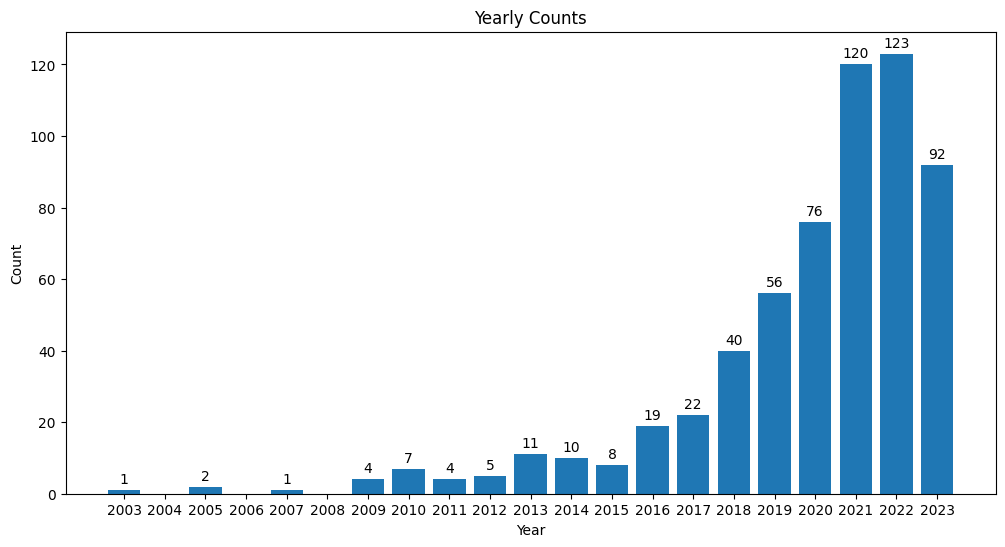

In [21]:
import matplotlib.pyplot as plt
import numpy as np

yearly_counts = df_new[df_new['data'] == 1]['year'].value_counts().reset_index()
yearly_counts.columns = ['Year', 'Count']
yearly_counts = yearly_counts.sort_values(by='Year')

fig, ax = plt.subplots(figsize=(12, 6))

ax.bar(yearly_counts['Year'], yearly_counts['Count'])
ax.set_xlabel('Year')
ax.set_ylabel('Count')
ax.set_title('Yearly Counts')

# x 축의 눈금 설정 (매년)
x_ticks = np.arange(yearly_counts['Year'].min(), yearly_counts['Year'].max() + 1)
ax.set_xticks(x_ticks)

# 막대 위에 숫자 표시
for i, count in enumerate(yearly_counts['Count']):
    ax.text(yearly_counts['Year'].iloc[i], count + 1, str(count), ha='center', va='bottom')

plt.show()

In [23]:
df_rev = df_new.groupby(['year', 'category']).size().unstack(fill_value=0).reset_index()
df_rev

category,year,AI Competence,Data Literacy,Digital Literacy,Knowledge Competence
0,2002,0,0,2,2
1,2003,0,1,1,2
2,2005,0,2,3,1
3,2006,0,0,6,3
4,2007,0,1,5,4
5,2008,0,0,6,1
6,2009,0,4,8,3
7,2010,0,7,14,1
8,2011,0,4,5,6
9,2012,0,5,18,3


## 각 키워드별로 연도별 상위 키워드를 추출하도록 한다.

In [25]:
import pandas as pd

# 데이터프레임 생성 (실제 데이터프레임 사용할 경우 생략)
def get_top_keywords(df, start_year, end_year, target_category, top_n=10):
    freq_dict = {}
    # 특정 연도와 카테고리에 해당하는 데이터 필터링
    filtered_df = df[(df['year'] >= start_year) & (df['year'] <= end_year) & (df['category'] == target_category)]
    
    count = len(filtered_df)
    
    for item in filtered_df['en_keyword']:
        if item is not np.nan:
            keys = item.split(',')

            for key in keys:
                if key not in freq_dict:
                    freq_dict[key] = 1
                else:
                    freq_dict[key] += 1
                
    # 빈도가 높은 순으로 정렬
    sorted_dict = dict(sorted(freq_dict.items(), key=lambda item: item[1], reverse=True))

    if top_n == -1:
        return count, sorted_dict, sum(freq_dict.values()), list(sorted_dict.items())
    else:
        return count, sorted_dict, sum(freq_dict.values()), list(sorted_dict.items())[:top_n]

In [26]:
years = [2003, 2009, 2014, 2019]
cats = ['Data Literacy']
file_names = ['Data/riss_dl']

for index, category in enumerate(cats):
    print(f'about {category}:\n')
    
    df = pd.read_excel(file_names[index] + '_r2.xlsx', index_col=0)
    
    for year in years:
        year_end = year + 5 if year == 2003 else year + 4
        print(f'from {year} to {year_end}\n')
        _, dict1, count, top_keywords = get_top_keywords(df, year, year_end, category, top_n=15)
        
        for key, val in top_keywords:
            print(f"{key}: {val}")
            
        print('\n')
    
    print('-'*30)

about Data Literacy:

from 2003 to 2008

image literacy: 1
image literacy class model: 1
gender: 1
information literacy: 1
information literacy attitudes: 1
information resources: 1
internet education: 1
library instruction: 1
literature review: 1
performance: 1
questionnaire: 1
related education: 1
undergraduate students: 1
computer literacy: 1
learning attitude: 1


from 2009 to 2013

media literacy education: 2
home economics: 2
family life culture: 2
academic writing: 2
media literacy constructs: 1
measurement of media litercy: 1
aged consumer: 1
use literacy: 1
production literacy: 1
news contents: 1
news literacy: 1
news education: 1
age: 1
pre-service elementary teacher: 1
elementary korean language teacher: 1


from 2014 to 2018

literacy: 8
information literacy: 5
ict literacy: 5
korean language education: 3
writing: 3
health literacy: 3
latent class analysis: 2
digital literacy education: 2
college writing: 2
digital literacy: 2
attitudes toward computer: 2
anxiety toward com

In [27]:
#과학교육 분야인지 아닌지 판단하는 내용임
cats = ['Data Literacy']
file_names = ['Data/riss_dl']
journals = ['과학영재교육', '초등과학교육', '과학교육연구지', '대한지구과학교육학회지', '현장과학교육', '한국과학교육학회지', '새물리']
keywords = ['science education', 'science teaching', 'science learning', 'physics education', 'physics learning',
           'physics teaching', 'chemical education', 'chemistry education', 'chemistry learning', 'chemistry teaching',
           'biological education', 'biology education', 'biology learning', 'biology teaching', 'earth science education',
           'science teacher', 'science student']

for index, category in enumerate(cats):
    print(f'about {category}:\n')
    
    df = pd.read_excel(file_names[index] + '_r2.xlsx', index_col=0)
    
    df['sciedu'] = 0
    
    for i in range(len(df)):
        if df.loc[i, 'journal'] in journals:
            df.loc[i, 'sciedu'] = 1
            continue
            
        if df.loc[i, 'en_title'] is np.nan:
            continue

        for item in keywords:
            if item in df.loc[i, 'en_title']:
                df.loc[i, 'sciedu'] = 1
                break

        if df.loc[i, 'sciedu'] == 1:
            continue

        if df.loc[i, 'en_keyword'] is np.nan:
            continue

        keys = df.loc[i, 'en_keyword'].split(',')

        for key in keys:
            if df.loc[i, 'en_keyword'] in keywords:
                df.loc[i, 'sciedu'] = 1
                break

    df.to_excel(file_names[index] + '_r2.xlsx')

about Data Literacy:

about Digital Literacy:

about AI Competence:

about Knowledge Competence:



In [29]:
for index, category in enumerate(cats):    
    df = pd.read_excel(file_names[index] + '_r2.xlsx', index_col=0)
    print(f"In {category}, {len(df[df['sciedu'] == 1])} articles belong to science education among {df.shape[0]} articles.\n")

In Data Literacy, 10 articles belong to science education among 601 articles.

In Digital Literacy, 9 articles belong to science education among 993 articles.

In AI Competence, 3 articles belong to science education among 581 articles.

In Knowledge Competence, 8 articles belong to science education among 170 articles.



# Network 그래프 그리기

In [34]:
import matplotlib.font_manager

# 현재 시스템에 설치된 글꼴 목록 가져오기
font_list = matplotlib.font_manager.findSystemFonts()

# 글꼴 목록 출력
for font_path in font_list:
    print(font_path)


/System/Library/Fonts/Supplemental/Al Tarikh.ttc
/System/Library/Fonts/LucidaGrande.ttc
/System/Library/Fonts/Supplemental/Sana.ttc
/Library/Fonts/a그해여름.otf
/System/Library/Fonts/Supplemental/Waseem.ttc
/Library/Fonts/a피라미드.otf
/System/Library/Fonts/Supplemental/NotoSansOldPersian-Regular.ttf
/System/Library/Fonts/MuktaMahee.ttc
/System/Library/Fonts/Supplemental/NotoSansMeroitic-Regular.ttf
/System/Library/Fonts/Supplemental/PTMono.ttc
/System/Library/Fonts/Supplemental/Bangla Sangam MN.ttc
/System/Library/Fonts/Supplemental/Sinhala Sangam MN.ttc
/System/Library/Fonts/SFCompact.ttf
/System/Library/Fonts/Supplemental/NotoSansSyriac-Regular.ttf
/System/Library/Fonts/Supplemental/Verdana Italic.ttf
/System/Library/Fonts/Supplemental/NotoSansMendeKikakui-Regular.ttf
/System/Library/Fonts/Apple Braille Outline 8 Dot.ttf
/System/Library/Fonts/Supplemental/Diwan Kufi.ttc
/System/Library/Fonts/Supplemental/Bangla MN.ttc
/Users/heavenly/Library/Fonts/SeoulNamsanEB.otf
/Users/heavenly/Library/F

In [42]:
plt.rc('font', family='AppleGothic')

### 여기서부터 반복 시행 (4회)

about Knowledge Competence:



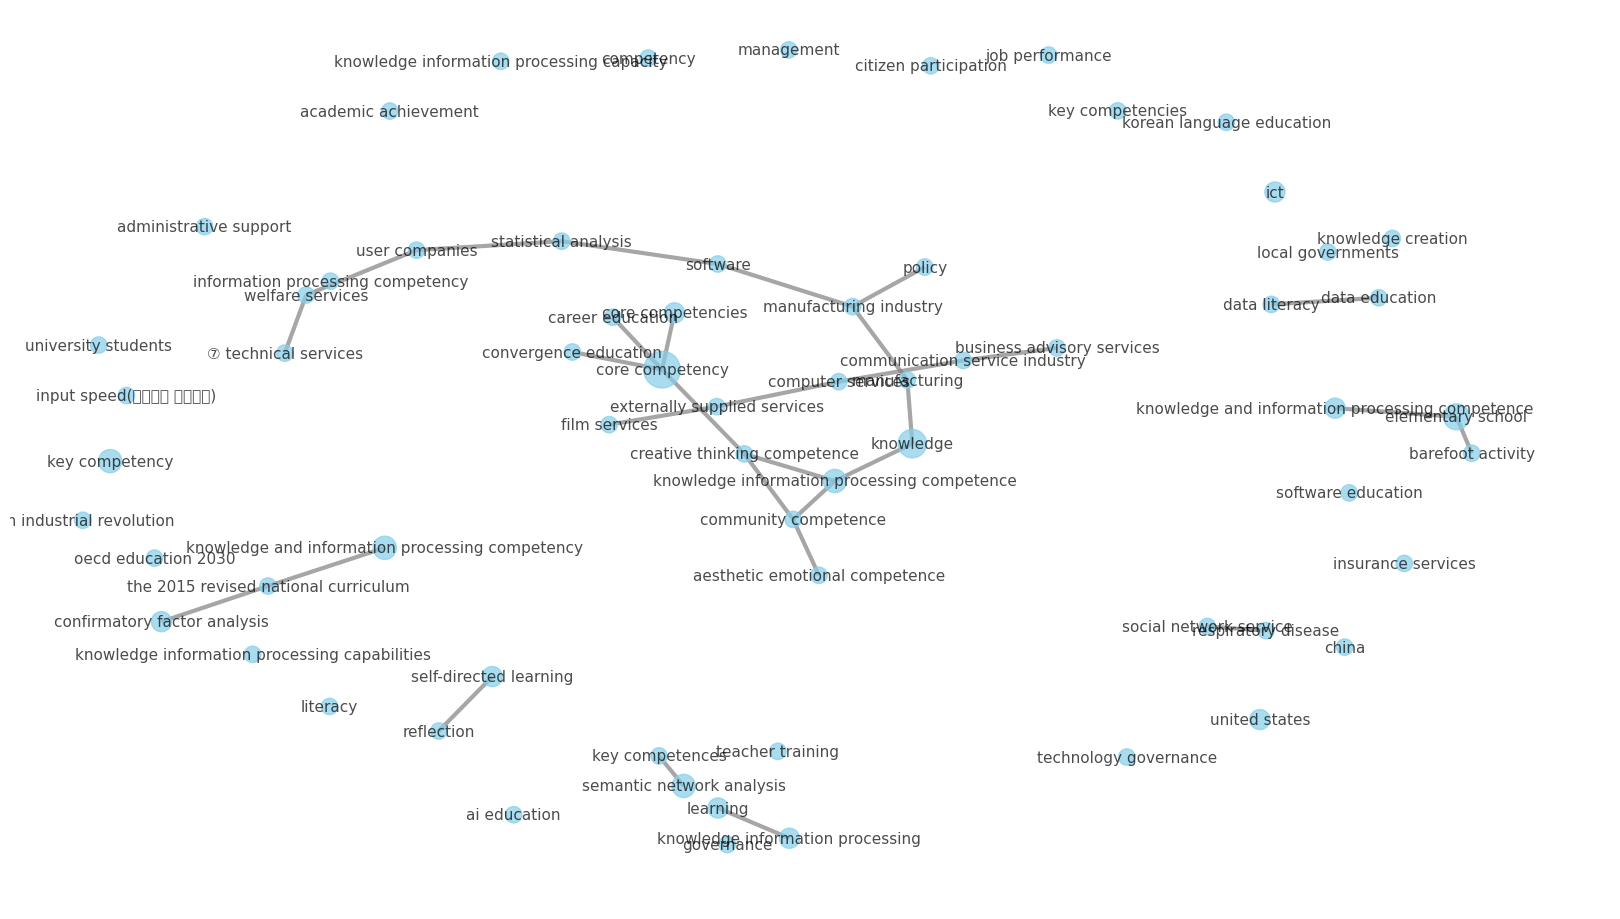

In [172]:
import networkx as nx
import matplotlib.pyplot as plt
from matplotlib.widgets import Button
import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings("ignore")

cats = ['Data Literacy']
file_names = ['Data/riss_dl']
index = 3
min_val = 4 if index == 1 else (2 if index == 3 else 3)
k = 12.5 if index == 0 else (2.5 if index ==3 else 20)
enz = 70

print(f'about {cats[index]}:\n')
df = pd.read_excel(file_names[index] + '_r2.xlsx', index_col=0)
data = []

for item in df.en_keyword:
    if (item is not np.nan) and (type(item) is not float):
        keys = item.split(',')
        if len(keys) >= 1: data.append(keys)

plt.figure(figsize=(16, 9))

# 빈도 계산
node_freq = {}
for sublist in data:
    for node in sublist:
        if node in node_freq:
            node_freq[node] += 1
        else:
            node_freq[node] = 1

# 그래프 생성
G = nx.Graph()

# 노드 추가 및 크기 설정 (빈도가 3 이상인 노드만 추가)
for node, freq in node_freq.items():
    if freq >= min_val:
        G.add_node(node, size=freq * enz)  # 노드 크기 설정

# 엣지 추가 (자기 자신에게 연결된 엣지는 제외)
for sublist in data:
    for i in range(len(sublist) - 1):
        if sublist[i] in G.nodes and sublist[i + 1] in G.nodes and sublist[i] != sublist[i + 1]:
            G.add_edge(sublist[i], sublist[i + 1])

# 스프링 레이아웃 계산
pos = nx.spring_layout(G, k=k / max(node_freq.values()))  # 빈도에 따라 스프링 강도를 조절
#pos = nx.kamada_kawai_layout(G, scale=100.0)

# 그래프 시각화 (엣지 투명도 추가)
node_sizes = [G.nodes[node]['size'] for node in G.nodes]
nx.draw(G, pos, with_labels=True, node_size=node_sizes, node_color='skyblue', cmap='Blues',
        font_size=11, font_color='black', edge_color='gray', width=3.0, style='solid', 
        alpha=0.7)  # 엣지 투명도 설정

plt.show()

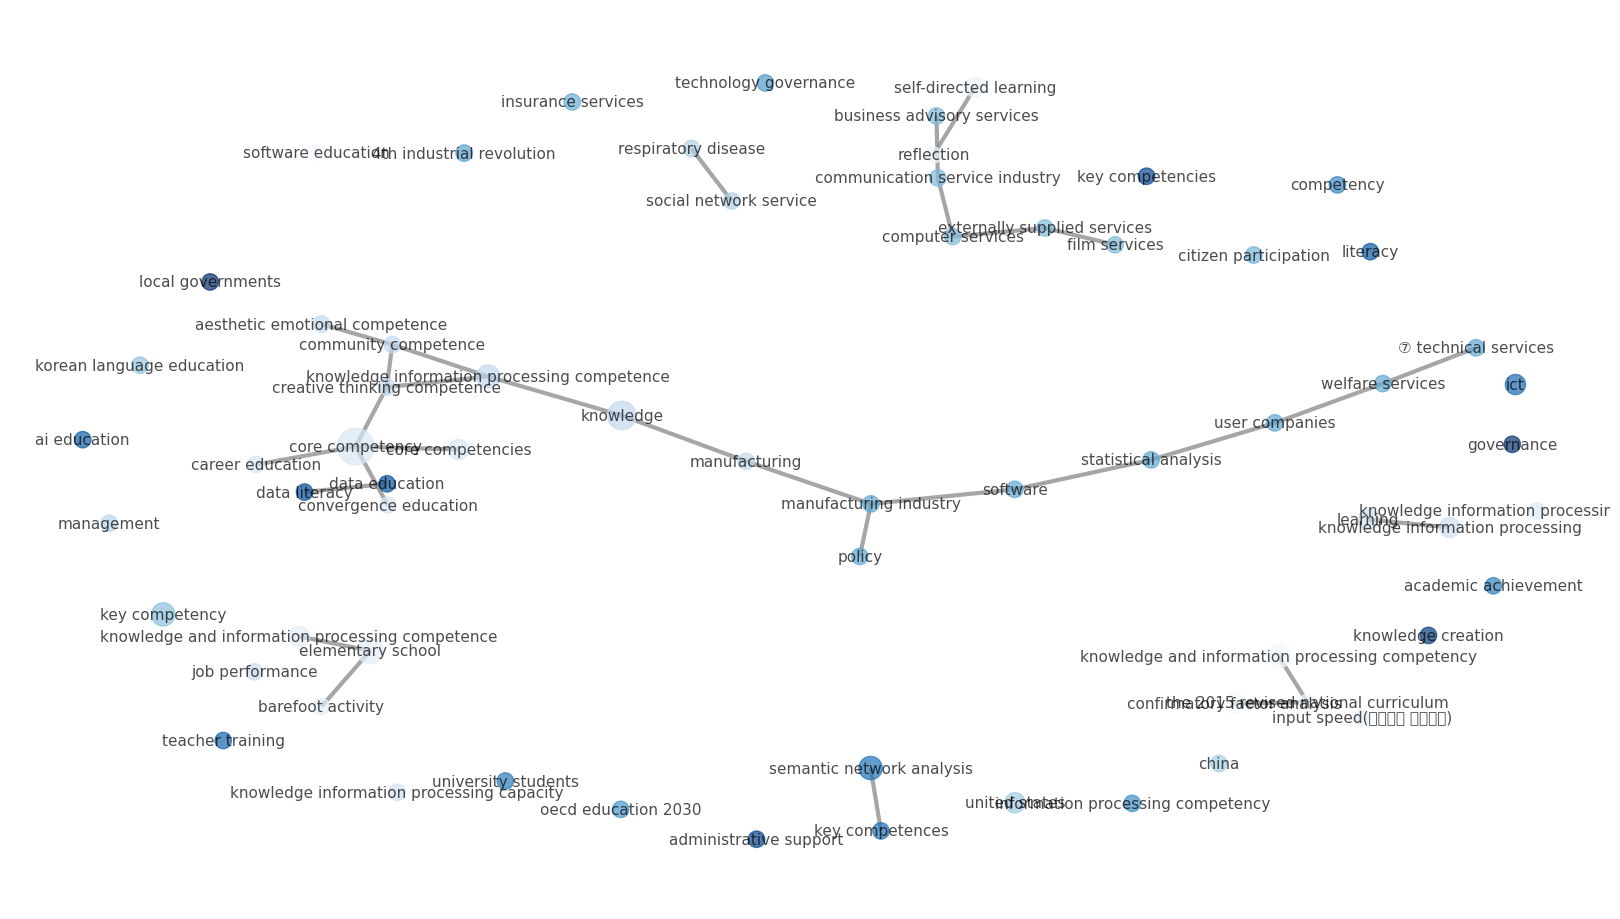

In [173]:
import networkx as nx
import matplotlib.pyplot as plt
from matplotlib.widgets import Button
import pandas as pd
import numpy as np
import warnings
import community  # Louvain 알고리즘을 사용하기 위한 라이브러리 추가
warnings.filterwarnings("ignore")

plt.figure(figsize=(16, 9))

# 그래프 생성
G = nx.Graph()

# 노드 추가 및 크기 설정 (빈도가 3 이상인 노드만 추가)
for node, freq in node_freq.items():
    if freq >= min_val:
        G.add_node(node, size=freq * 70)  # 노드 크기 설정

# 엣지 추가 (자기 자신에게 연결된 엣지는 제외)
for sublist in data:
    for i in range(len(sublist) - 1):
        if sublist[i] in G.nodes and sublist[i + 1] in G.nodes and sublist[i] != sublist[i + 1]:
            G.add_edge(sublist[i], sublist[i + 1])

# Louvain 알고리즘을 사용하여 커뮤니티 탐색
partition = community.best_partition(G)

# 스프링 레이아웃 계산
pos = nx.spring_layout(G, k=k / max(node_freq.values()))  # 빈도에 따라 스프링 강도를 조절

# 커뮤니티 정보를 이용하여 색상 지정
node_colors = [partition[node] for node in G.nodes]

# 그래프 시각화 (엣지 투명도 추가)
node_sizes = [G.nodes[node]['size'] for node in G.nodes]
nx.draw(G, pos, with_labels=True, node_size=node_sizes, node_color=node_colors, cmap='Blues',
        font_size=11, font_color='black', edge_color='gray', width=3.0, style='solid', 
        alpha=0.7)  # 엣지 투명도 설정

plt.show()

In [174]:
# Louvain 알고리즘을 사용하여 커뮤니티 탐색
partition = community.best_partition(G)

# 클러스터의 개수 확인
cluster_count = len(set(partition.values()))

print(f"Number of clusters: {cluster_count}")

Number of clusters: 40


In [175]:
cluster_dict = {}  # 클러스터별로 노드를 그룹화할 딕셔너리

for node, cluster_id in partition.items():
    if cluster_id in cluster_dict:
        cluster_dict[cluster_id].append(node)
    else:
        cluster_dict[cluster_id] = [node]

# 각 클러스터에 속한 노드 출력
for cluster_id, nodes in cluster_dict.items():
    print(f"Cluster {cluster_id}: {nodes}")


Cluster 0: ['software education']
Cluster 1: ['knowledge and information processing competency', 'the 2015 revised national curriculum', 'confirmatory factor analysis']
Cluster 2: ['self-directed learning', 'reflection']
Cluster 10: ['knowledge information processing competence', 'aesthetic emotional competence', 'creative thinking competence', 'community competence']
Cluster 4: ['knowledge and information processing competence', 'elementary school', 'barefoot activity']
Cluster 5: ['knowledge information processing capabilities']
Cluster 6: ['core competency', 'core competencies', 'career education', 'convergence education']
Cluster 7: ['knowledge information processing capacity']
Cluster 8: ['knowledge information processing', 'learning']
Cluster 9: ['job performance']
Cluster 20: ['manufacturing', 'knowledge', 'manufacturing industry', 'policy']
Cluster 11: ['management']
Cluster 12: ['respiratory disease', 'social network service']
Cluster 13: ['china']
Cluster 14: ['united states'